# Import

In [1]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

In [2]:
def sort_models(df: pd.DataFrame):
    x = df[
        ["dev_p_F1score", "dev_s_F1score"]
    ].values.copy()  # ,"dev_p_modified_MAE","dev_s_modified_MAE"
    # x[:, 2:] = 1 / x[:, 2:]
    x /= np.nanmax(x, axis=0, keepdims=True)
    means = np.mean(x, axis=1)
    # print(means)
    if np.isnan(means).all():
        return None
    df["scores"] = means
    df.sort_values(by=["scores"], ascending=False, ignore_index=True, inplace=True)


def rank_models(df: pd.DataFrame):
    x = df[
        ["dev_p_F1score", "dev_s_F1score", "dev_p_modified_MAE2", "dev_s_modified_MAE2"]
    ].values.copy()  # ,"dev_p_modified_MAE","dev_s_modified_MAE"
    x[:, :2] = rankdata(x[:, :2], axis=0)
    x[:, 2:] = rankdata(-x[:, 2:], axis=0)
    # x[:, 2:] = 1 / x[:, 2:]
    # x /= np.nanmax(x, axis=0, keepdims=True)
    means = np.mean(x, axis=1)
    # print(means)
    if np.isnan(means).all():
        return None
    df["average_rank"] = means
    df[["p_f1_rank", "s_f1_rank", "p_mae_rank", "s_mae_rank"]] = x
    # df.sort_values(by=["scores"],ascending=False, ignore_index=True, inplace=True)


def generate_metadata(row):
    meta = {
        "docstring": "Model trained on volcanic earthquakes with a learning rate of LR.\n"
        "Threshold selected for optimal F1 score on the validation set. Depending on the target region, the thresholds might need to be adjusted.\nWhen using this model, please reference\n\nYiyuan Zhong and Yen Joe Tan (2024). Deep-learning-based phase picking for volcano seismicity, submitted.",
        "model_args": {
            "component_order": "ZNE",
        },
        "seisbench_requirement": "0.4.0",
        "version": "1",
    }
    default_args = {}
    meta["docstring"] = meta["docstring"].replace("LR", str(row["lr"]))
    meta["docstring"] = meta["docstring"].replace("MAXEPOCH", str(row["max_epoch"]))
    if row["model"] == "eqtransformer":
        det_threshold = row["det_threshold"]
        if np.isnan(det_threshold):
            det_threshold = (
                0.3  # Roughly the average detection threshold across datasets
            )
        default_args["detection_threshold"] = det_threshold
    elif row["model"] == "phasenet":
        meta["model_args"]["phases"] = "PSN"
    else:
        raise ValueError("Unknown model type")
    default_args["P_threshold"] = float(
        f"{row['p_opt_prob_thre']:.3f}"
    )  # to avoid precision loss in the output, e.g. 0.22 becoming 0.2199999999
    default_args["S_threshold"] = float(f"{row['s_opt_prob_thre']:.3f}")

    meta["model_args"]["norm"] = "peak"
    meta["default_args"] = default_args
    return meta


def export_model(
    row,
    models_path,
    output_base=Path("seisbench_models"),
    filename="volpick",
    version_str="1",
    to_cpu=False,
):
    weights = Path(models_path) / row["exp_name"]
    version = sorted(list(weights.iterdir()), key=lambda x: int(x.name.split("_")[1]))[
        -1
    ]
    config_path = version / "hparams.yaml"
    with open(config_path, "r") as f:
        config = yaml.full_load(f)

    model_cls = models.__getattribute__(config["model"] + "Lit")
    lightning_model = load_best_model(model_cls, weights, version.name)
    output_base = Path(output_base)
    output_path = output_base / row["model"] / f"{filename}.pt.v{version_str}"
    json_path = output_base / row["model"] / f"{filename}.json.v{version_str}"
    output_path.parent.mkdir(parents=True, exist_ok=True)
    if to_cpu:
        print("Move model to cpu")
        lightning_model.model.to(torch.device("cpu"))
    torch.save(lightning_model.model.state_dict(), output_path)

    meta = generate_metadata(row)
    with open(json_path, "w") as f:
        json.dump(meta, f, indent=4)

# Generate configuration files (run only once)

In [4]:
# batch_size_c={1024:0,512:0,256:0}
# for i in range(10000):
#     batch_size=int(np.random.choice([1024, 512, 256]))
#     lr_exponent=np.random.uniform(low=-4.5,high=-2)
#     lrearning_rate=round(10**lr_exponent,5)
#     # print(lrearning_rate)
#     # print(batch_size)
#     batch_size_c[batch_size]+=1

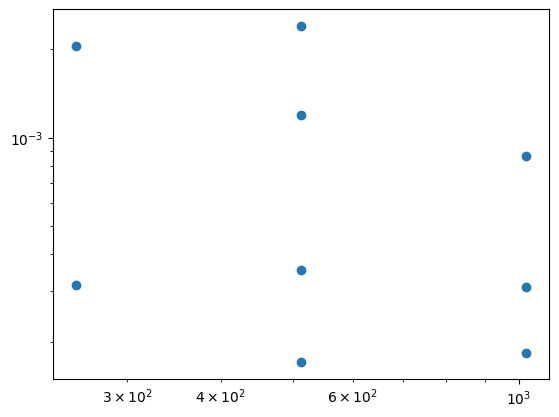

In [421]:
# np.random.seed(85)
# batch_sizes=np.random.choice([1024, 512, 256],size=9,replace=True)
# lr_exponents=np.random.uniform(low=-4.1,high=-2.5,size=9)
# learning_rates=10**lr_exponents
# # for i in range(10):
# #     batch_size=int(np.random.choice([1024, 512, 256,128,64]))
# #     lr_exponent=np.random.uniform(low=-5.0,high=-2.0)
# #     learning_rate=round(10**lr_exponent,5)
# #     batch_sizes[i]=batch_size
# #     learning_rates[i]=learning_rate
# plt.loglog(batch_sizes,learning_rates,'o')

In [6]:
config_tune_dir=Path("./configs_tune")
try:
    config_tune_dir.mkdir(parents=True,exist_ok=False)
except FileExistsError:
    print(f"{config_tune_dir} exists")

In [9]:
np.random.choice([0,1])

1

In [53]:
models = ["PhaseNet", "EQTransformer"]
data_path = "/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis"
# shapes = ["gaussian", "triangle"]
model_name_abbreviations = {"PhaseNet": "p", "EQTransformer": "e"}
shape="gaussian"
# sigma = 20
# max_epoch = 200
# pretrained_model = None
# stack_data = True
learning_rates=[1e-4,5e-4,1e-3]
batch_sizes=[512,1024]
sigmas=[10,20]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for sigma in sigmas:
            shape="gaussian"
            max_epoch = 400
            pretrained_model = None
            stack_data = True
            for model in models:
                config = {
                    "model": model,
                    "pretrained": pretrained_model,
                    "data": data_path,
                    "read_data_method": "path",
                    "training_fraction": 1,
                    "trainer_args": {
                        "accelerator": "gpu",
                        "devices": [int(np.random.choice([0,1]))],
                        "max_epochs": max_epoch,
                    },
                    "model_args": {
                        "sample_boundaries": [None, None],
                        "lr": learning_rate,
                        "norm": "peak",
                        "sigma": sigma,
                        "prob_label_shape": shape,
                        "lr_scheduler": "ReduceLROnPlateau",
                        "lr_scheduler_args": {
                            "factor": 0.5,
                            "patience": 20,
                            "min_lr": 1e-6,
                        },
                    },
                    "stack_data": stack_data,
                    "batch_size": batch_size,
                    "num_workers": 24,
                }
                config_filename = f"{model_name_abbreviations[model]}_{batch_size}_{learning_rate:.0e}_{shape[:2]}{sigma}_{max_epoch}"
                if stack_data:
                    config_filename = config_filename + "_s"
                if pretrained_model:
                    config_filename = config_filename + f"pr{pretrained_model}"
                with open(
                    config_tune_dir/f"{config_filename}.json", "w"
                ) as json_file:
                    json.dump(config, json_file, indent=2)

In [61]:
config_dir=Path("/home/zhongyiyuan/volpick/model_training/configs_tune")
config_files_gpu0=[]
config_files_gpu1=[]
for config_file in config_dir.iterdir():
    with open(config_file, "r") as f:
        config = json.load(f)
        if config["trainer_args"]["devices"]==[0]:
            config_files_gpu0.append(config_file.name)
        elif config["trainer_args"]["devices"]==[1]:
            config_files_gpu1.append(config_file.name)
config_files_gpu0.sort(key=lambda x: x[2:])
config_files_gpu1.sort(key=lambda x: x[2:])            

In [62]:
print("(\n"+"\n".join(config_files_gpu0)+"\n)")

(
p_1024_1e-03_ga10_400_s.json
p_1024_1e-03_ga20_400_s.json
e_1024_1e-04_ga10_400_s.json
p_1024_1e-04_ga10_400_s.json
p_1024_1e-04_ga20_400_s.json
e_1024_5e-04_ga10_400_s.json
p_512_1e-03_ga10_400_s.json
e_512_1e-04_ga20_400_s.json
p_512_5e-04_ga10_400_s.json
e_512_5e-04_ga20_400_s.json
p_512_5e-04_ga20_400_s.json
)


In [63]:
print("(\n"+"\n".join(config_files_gpu1)+"\n)")

(
e_1024_1e-03_ga10_400_s.json
e_1024_1e-03_ga20_400_s.json
e_1024_1e-04_ga20_400_s.json
p_1024_5e-04_ga10_400_s.json
e_1024_5e-04_ga20_400_s.json
p_1024_5e-04_ga20_400_s.json
e_512_1e-03_ga10_400_s.json
p_512_1e-03_ga20_400_s.json
e_512_1e-03_ga20_400_s.json
e_512_1e-04_ga10_400_s.json
p_512_1e-04_ga10_400_s.json
p_512_1e-04_ga20_400_s.json
e_512_5e-04_ga10_400_s.json
)


# Datasets

In [2]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 52864/52864 [00:09<00:00, 5872.78it/s] 


In [3]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

Number of traces in the test set and the development set:
30168 lp and noise traces
30235 vt and noise traces
22629 lp traces
22696 regular earthquake traces
7539 noise earthquake traces


In [5]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

# the component order of input matrices of phasenet is ENZ
dataset_ENZ = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ENZ",
    dimension_order="NCW",
    cache="full",
)
dataset_ENZ.filter(dataset_ENZ["split"].isin(["dev", "test"]), inplace=True)
dataset_ENZ.preload_waveforms(pbar=True)
dataset_ENZ_lp_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] == "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_ENZ_rg_and_noise = dataset_ENZ.filter(
    (dataset_ENZ.metadata["source_type"] != "lp")
    | (dataset_ENZ.metadata["source_type"] == "noise"),
    inplace=False,
)

Preloading waveforms: 100%|██████████| 52864/52864 [00:11<00:00, 4520.49it/s]


Target paths

In [4]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


In [12]:
list(np.array([1,2]))

[1, 2]

In [5]:
replace_if_exist=False
generate_task0(dataset=dataset, output=targets_path_lp_and_rg, sampling_rate=100, noise_before_events=False, keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset, output=targets_path_lp_and_rg, sampling_rate=100, noise_before_events=False, replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset, output=targets_path_lp_and_rg, sampling_rate=100, replace_if_exist=replace_if_exist)

100%|██████████| 52864/52864 [00:17<00:00, 2989.63it/s]


In [6]:
replace_if_exist=False
generate_task0(dataset=dataset_lp_and_noise, output=targets_path_lp, sampling_rate=100, noise_before_events=False,keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset_lp_and_noise, output=targets_path_lp, sampling_rate=100, noise_before_events=False,replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset_lp_and_noise, output=targets_path_lp, sampling_rate=100,replace_if_exist=replace_if_exist)

100%|██████████| 30168/30168 [00:09<00:00, 3219.71it/s]


In [7]:
generate_task0(dataset=dataset_rg_and_noise, output=targets_path_rg, sampling_rate=100, noise_before_events=False,keep_source_type=True, replace_if_exist=replace_if_exist)
generate_task1(dataset=dataset_rg_and_noise, output=targets_path_rg, sampling_rate=100, noise_before_events=False,replace_if_exist=replace_if_exist)
generate_task23(dataset=dataset_rg_and_noise, output=targets_path_rg, sampling_rate=100,replace_if_exist=replace_if_exist)

  0%|          | 0/30235 [00:00<?, ?it/s]

100%|██████████| 30235/30235 [00:13<00:00, 2170.46it/s]


# Tune hyperparameters

In [7]:
models_root_path=Path("/home/zhongyiyuan/volpick/model_training/weights")
#model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs=[x.name for x in models_root_path.iterdir()]
model_dirs

['e_1024_5e-04_ga10_400_s',
 'p_1024_1e-03_ga20_400_s',
 'e_1024_1e-03_ga10_400_s',
 'p_1024_5e-04_ga10_400_s',
 'e_1024_1e-04_ga10_400_s',
 'p_1024_1e-04_ga10_400_s',
 'e_1024_1e-03_ga20_400_s_preinstance',
 'p_1024_5e-04_ga20_400_s',
 'p_512_5e-04_ga10_400_s',
 'e_512_1e-03_ga10_400_s',
 'p_512_5e-04_ga20_400_s',
 'p_512_1e-03_ga10_400_s',
 'e_512_1e-04_ga20_400_s',
 'e_1024_1e-03_ga20_400_s',
 'p_512_1e-04_ga20_400_s',
 'p_512_1e-03_ga20_400_s',
 'e_512_5e-04_ga20_400_s',
 'e_512_5e-04_ga10_400_s',
 'p_512_1e-04_ga10_400_s',
 'e_512_1e-03_ga20_400_s',
 'e_1024_1e-04_ga20_400_s',
 'e_512_1e-04_ga10_400_s',
 'p_1024_1e-03_ga10_400_s',
 'p_512_5e-04_ga20_400_s_preinstance',
 'e_1024_5e-04_ga20_400_s',
 'p_1024_1e-04_ga20_400_s']

0.0109559213742613
/home/zhongyiyuan/volpick/model_training/weights/e_1024_5e-04_ga10_400_s/version_0
0.0421896129846572
/home/zhongyiyuan/volpick/model_training/weights/p_1024_1e-03_ga20_400_s/version_0
0.0106689734384417
/home/zhongyiyuan/volpick/model_training/weights/e_1024_1e-03_ga10_400_s/version_0
0.0256135500967502
/home/zhongyiyuan/volpick/model_training/weights/p_1024_5e-04_ga10_400_s/version_0
0.0117785707116127
/home/zhongyiyuan/volpick/model_training/weights/e_1024_1e-04_ga10_400_s/version_0
0.0270670969039201
/home/zhongyiyuan/volpick/model_training/weights/p_1024_1e-04_ga10_400_s/version_0
0.0422947593033313
/home/zhongyiyuan/volpick/model_training/weights/p_1024_5e-04_ga20_400_s/version_0
0.0253152027726173
/home/zhongyiyuan/volpick/model_training/weights/p_512_5e-04_ga10_400_s/version_0
0.0106239011511206
/home/zhongyiyuan/volpick/model_training/weights/e_512_1e-03_ga10_400_s/version_0
0.0420240610837936
/home/zhongyiyuan/volpick/model_training/weights/p_512_5e-04_ga20

/home/zhongyiyuan/volpick/volpick/model/utils.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex="col")


/home/zhongyiyuan/volpick/model_training/weights/e_512_1e-04_ga10_400_s/version_0
0.0255465265363454
/home/zhongyiyuan/volpick/model_training/weights/p_1024_1e-03_ga10_400_s/version_0
0.0159898716956377
/home/zhongyiyuan/volpick/model_training/weights/e_1024_5e-04_ga20_400_s/version_0
0.0439481250941753
/home/zhongyiyuan/volpick/model_training/weights/p_1024_1e-04_ga20_400_s/version_0


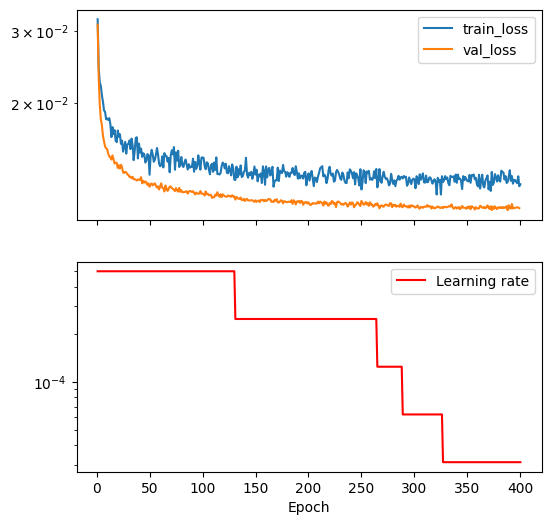

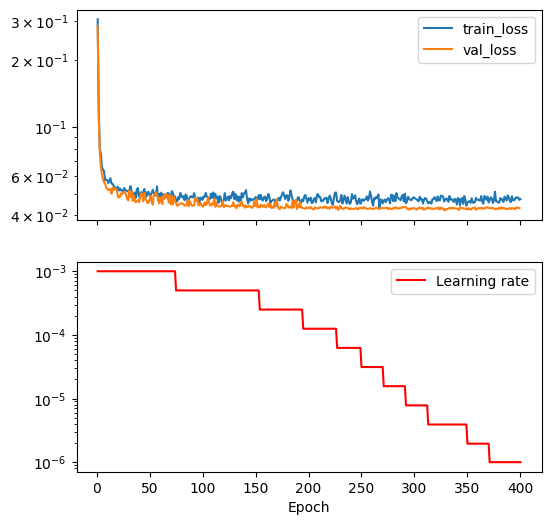

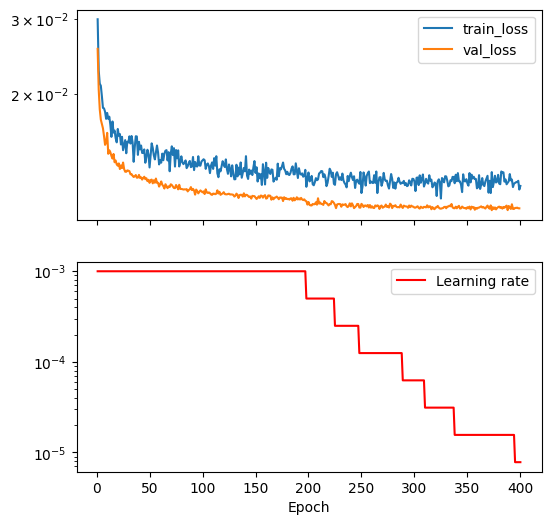

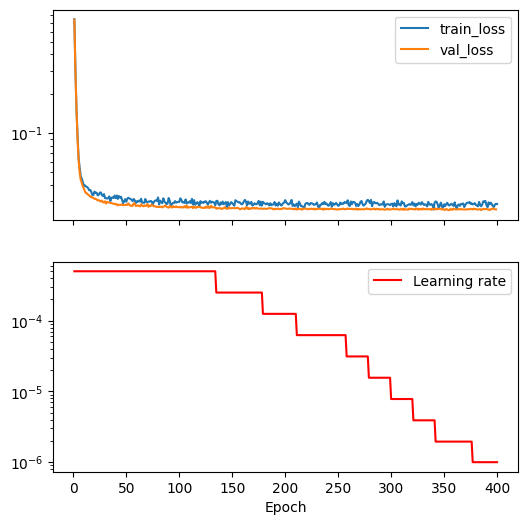

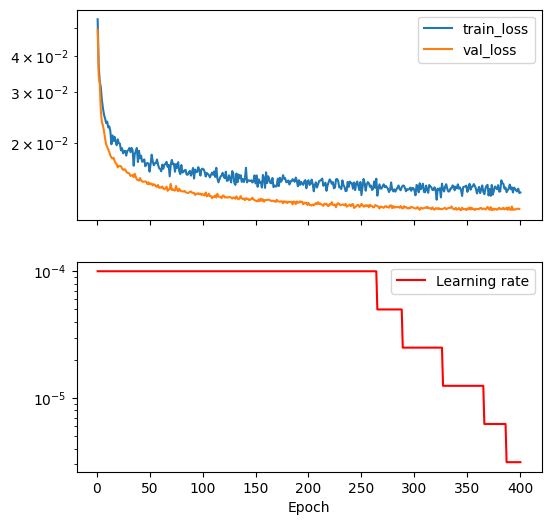

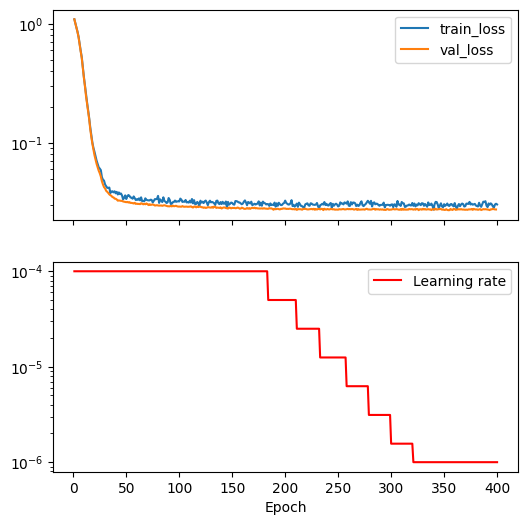

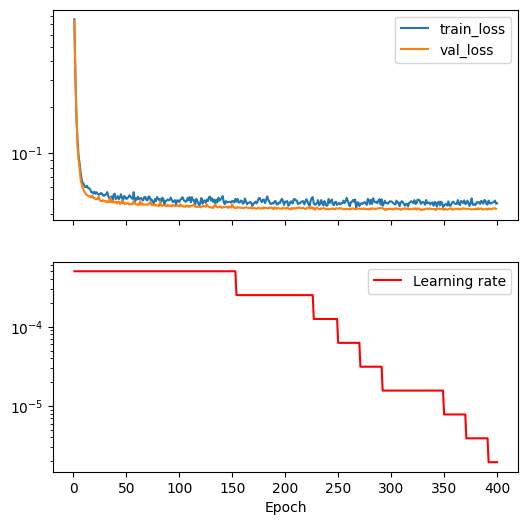

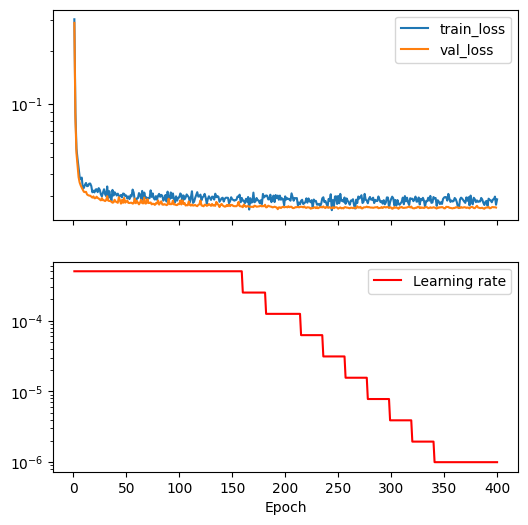

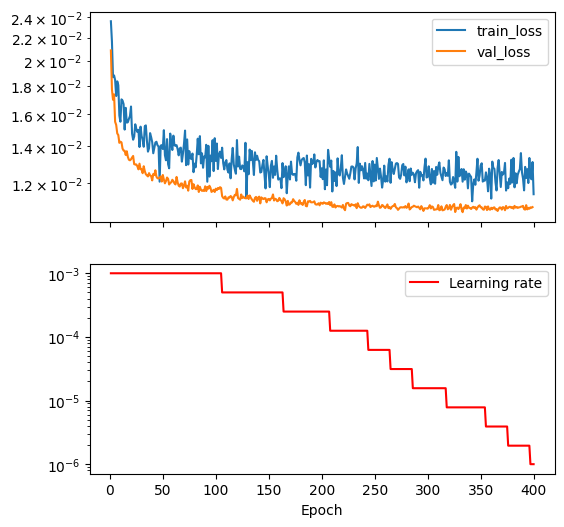

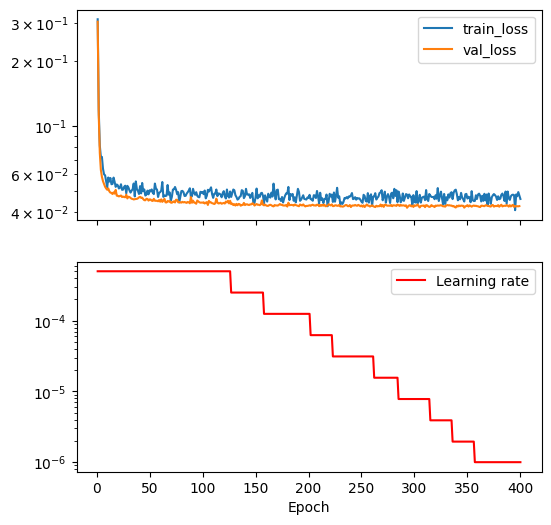

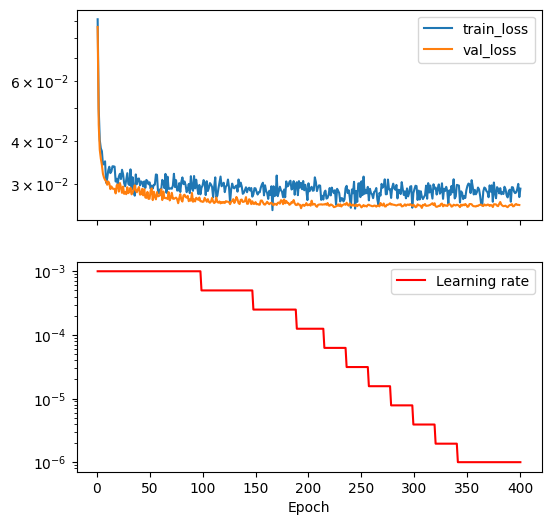

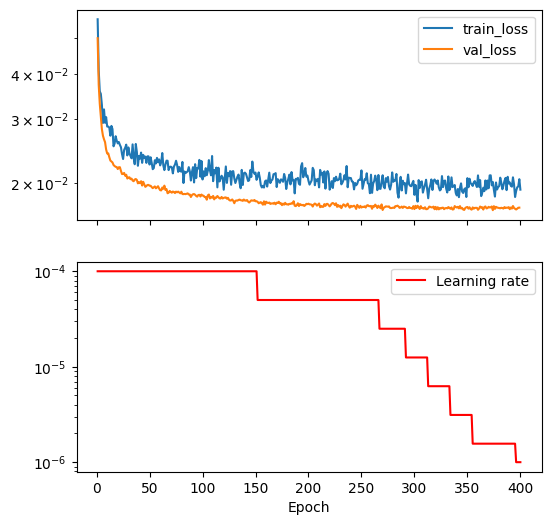

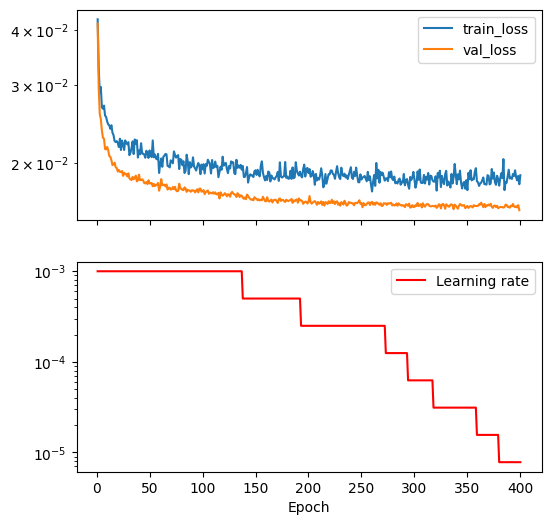

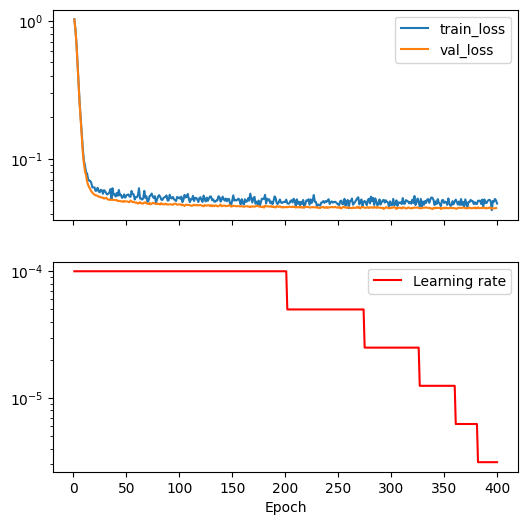

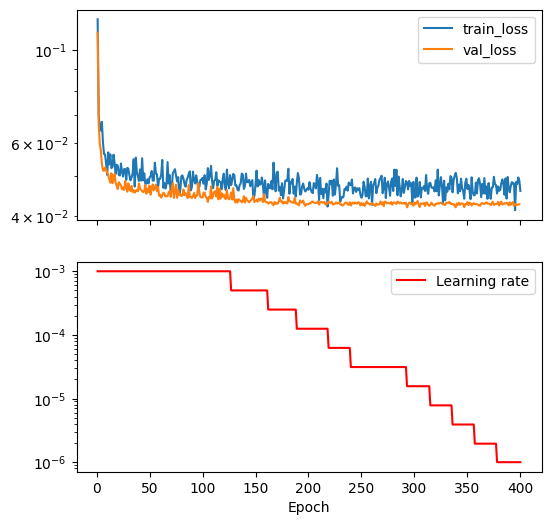

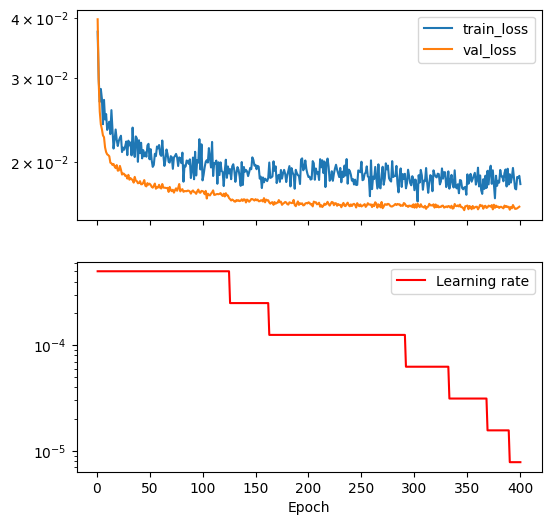

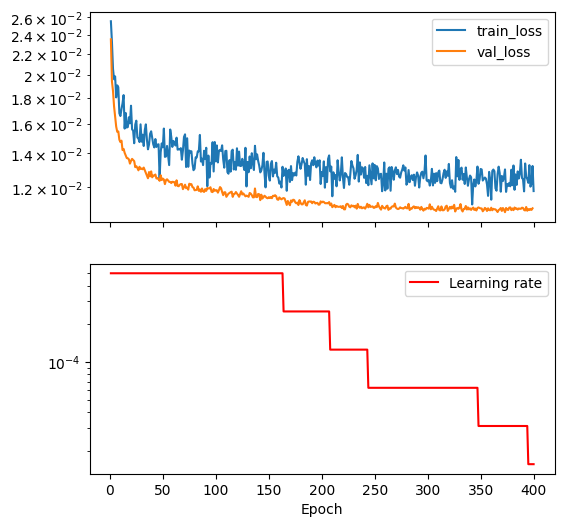

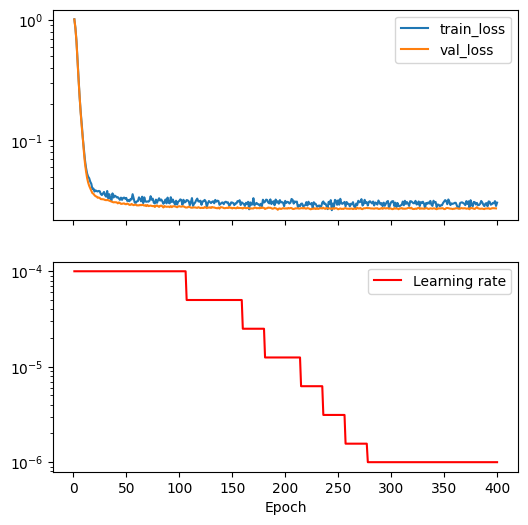

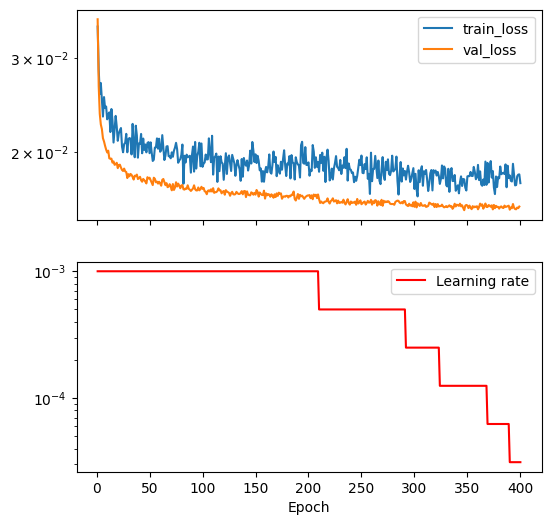

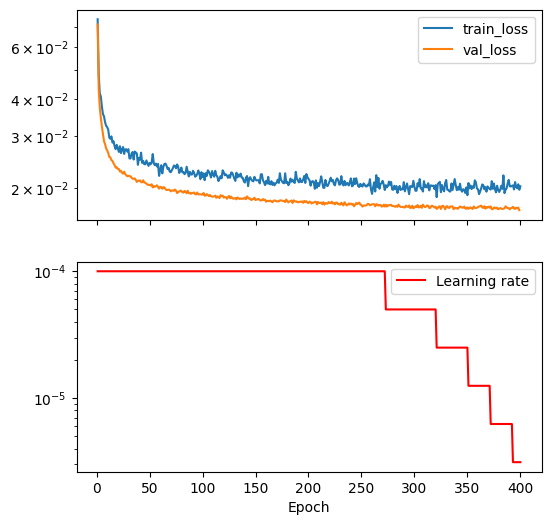

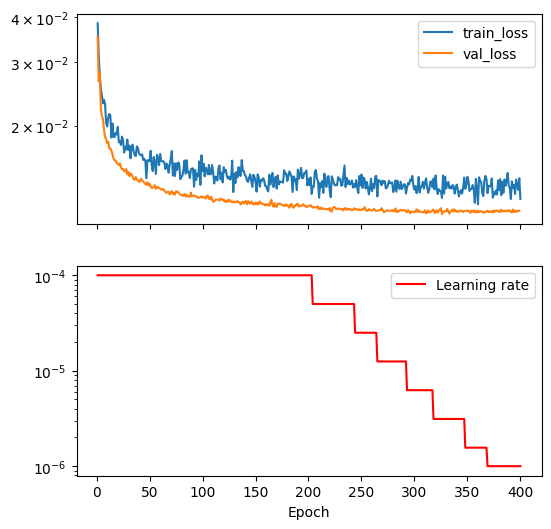

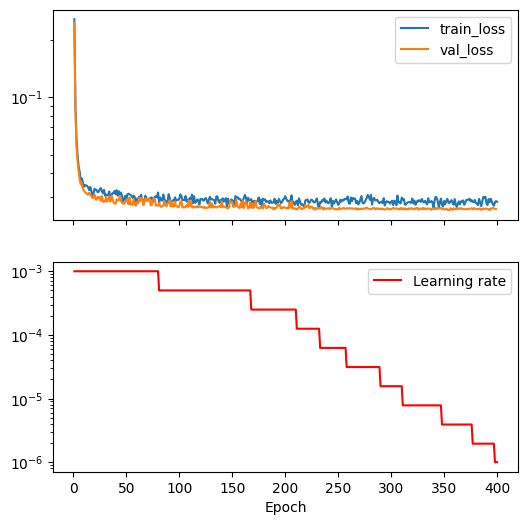

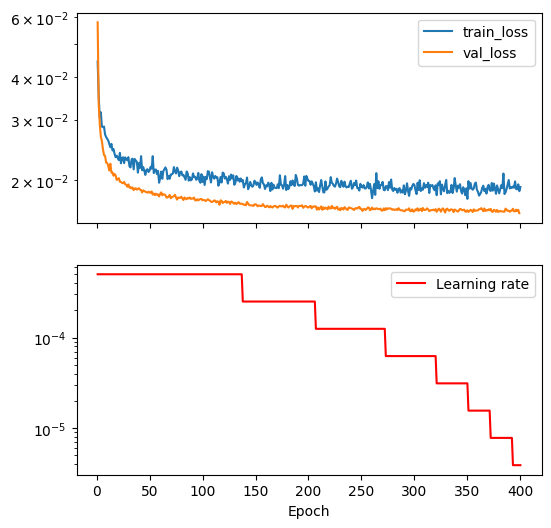

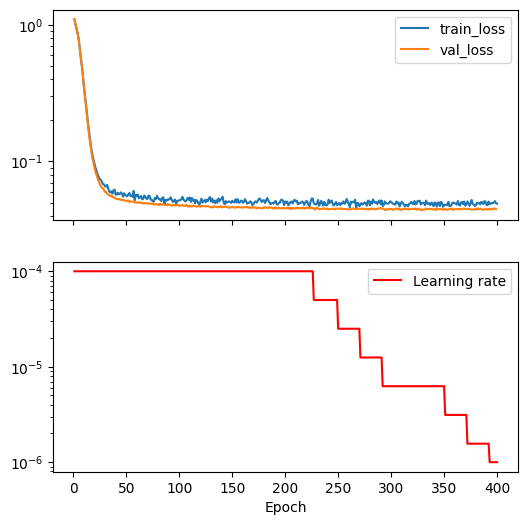

In [42]:
for model_dirname in model_dirs:
    model_path=Path("/home/zhongyiyuan/volpick/model_training/weights")/model_dirname
    pl_model=load_best_model_from_base_dir(model_path)

### Task0

Use the strict definition of FP/FN

In [10]:
len(np.arange(0.1,0.5,0.01))

40

In [8]:
tp_thre=0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list=[targets_path_lp_and_rg]
dataset_list=[dataset]

for model_dirname in model_dirs:
    model_path=Path("/home/zhongyiyuan/volpick/model_training/weights")/model_dirname
    pl_model=load_best_model_from_base_dir(model_path,plot_loss=False)
    model=pl_model.model
    for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(dev_test_set=dataset_i,
                    model=model, 
                    exp_name=f"{model_path.name}",
                    targets_path=target_i,
                    root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_tune",
                    # prob_thres=np.array([0.27,0.3,0.32]),
                    # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
                    prob_thres=np.arange(0.12,0.42,0.01),
                    num_workers=32,
                    batchsize=2048,
                    num_test_run=-1,
                    output_remark="pred",
                    tp_thre=tp_thre,
                    sets=["dev"],
                    # sets=["train", "dev","test"],
                    # append_to_file=True,
                    data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/e_1024_5e-04_ga10_400_s exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 224636.76it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 163446.50it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 178882.99it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 164851.22it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 164443.62it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 182525.18it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 162878.11it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 171626.40it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 158307.27it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 179934.79it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 173245.64it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160769.83it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 162206.11it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 217204.88it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 323540.64it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 239818.16it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 166115.87it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 185395.61it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 166327.11it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 183197.78it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 280047.45it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 165577.77it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 177618.03it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160126.79it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160349.66it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410
/home/zhongyiyuan/volpick/model_training/Eval_tune/all_

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160616.82it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability threshold: 0.310
Probability threshold: 0.320
Probability threshold: 0.330
Probability threshold: 0.340
Probability threshold: 0.350
Probability threshold: 0.360
Probability threshold: 0.370
Probability threshold: 0.380
Probability threshold: 0.390
Probability threshold: 0.400
Probability threshold: 0.410


Use the loose definition fo FP/FN from Zhu 2019 and Mousavi 2020

In [22]:
model_dirs

['e_1024_1e-03_ga20_400_s']

0.0157019942998886
/home/zhongyiyuan/volpick/model_training/weights/e_1024_1e-03_ga20_400_s/version_0
/home/zhongyiyuan/volpick/model_training/Eval_tune1/all_pred/task0/e_1024_1e-03_ga20_400_s exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 158520.37it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.215
Probability threshold: 0.225
Probability threshold: 0.245
Probability threshold: 0.255


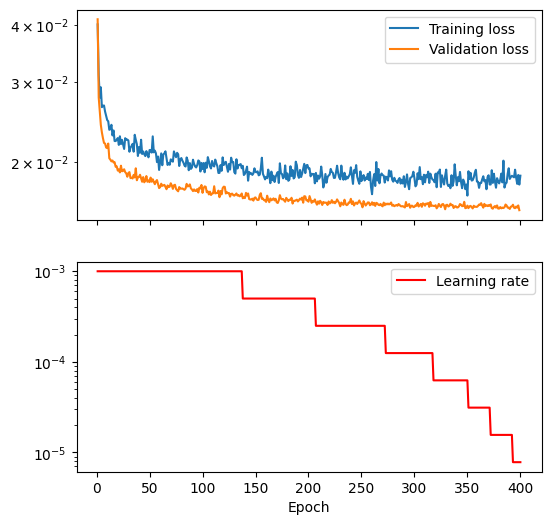

In [23]:
tp_thre=0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list=[targets_path_lp_and_rg]
dataset_list=[dataset]

for model_dirname in model_dirs:
    model_path=Path("/home/zhongyiyuan/volpick/model_training/weights")/model_dirname
    pl_model=load_best_model_from_base_dir(model_path)
    model=pl_model.model
    for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(dev_test_set=dataset_i,
                    model=model, 
                    exp_name=f"{model_path.name}",
                    targets_path=target_i,
                    root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_tune1",
                    # prob_thres=np.array([0.27,0.3,0.32]),
                    # prob_thres=np.array([0.18,0.20,0.22,0.25,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
                    prob_thres=np.arange(0.1,0.45,0.01),
                    num_workers=16,
                    batchsize=1024,
                    num_test_run=-1,
                    output_remark="pred",
                    tp_thre=tp_thre,
                    sets=["dev"],
                    # sets=["train", "dev","test"],
                    data_norm_type=model.norm,
                    count_tp_method=1)

Compare results

In [133]:
root_save_dir=Path("/home/zhongyiyuan/volpick/model_training/Eval_tune")

pred_dirs=[root_save_dir/f"{x.name}_pred" for x in target_path_list]
for pred_dir in pred_dirs:
    print(pred_dir/"task0")
    collect_task0_results_dev(pred_dir/"task0")
    
df0=pd.read_csv("/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/task0_metrics_sum.csv")

df0_phasenet=df0[df0["model"]=="phasenet"].copy()
df0_eqt=df0[df0["model"]=="eqtransformer"].copy()
# sort_models(df0_phasenet)
# rank_models(df0_phasenet)
# sort_models(df0_eqt)
# rank_models(df0_eqt)


# df0_phasenet.sort_values(by=["model","scores"],ascending=False, ignore_index=True, inplace=True)
# df0_eqt.sort_values(by=["model","scores"],ascending=False, ignore_index=True, inplace=True)

# df0_phasenet.to_csv("/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/pn_task0_metrics_sum_sorted.csv",index=False)
# df0_eqt.to_csv("/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/eqt_task0_metrics_sum_sorted.csv",index=False)

sort_models(df0)
rank_models(df0)
df0.sort_values(by=["model","scores"],ascending=False, ignore_index=True, inplace=True)
df0.to_csv("/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/task0_metrics_sum_sorted.csv",index=False)

/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0
e_1024_5e-04_ga10_400_s
p_1024_1e-03_ga20_400_s
e_1024_1e-03_ga10_400_s
p_1024_5e-04_ga10_400_s
e_1024_1e-04_ga10_400_s
p_1024_1e-04_ga10_400_s
e_1024_1e-03_ga20_400_s_preinstance
p_1024_5e-04_ga20_400_s
p_512_5e-04_ga10_400_s
e_512_1e-03_ga10_400_s
p_512_5e-04_ga20_400_s
p_512_1e-03_ga10_400_s
e_512_1e-04_ga20_400_s
e_1024_1e-03_ga20_400_s
p_512_1e-04_ga20_400_s
p_512_1e-03_ga20_400_s
e_512_5e-04_ga20_400_s
e_512_5e-04_ga10_400_s
p_512_1e-04_ga10_400_s
e_512_1e-03_ga20_400_s
e_1024_1e-04_ga20_400_s
e_512_1e-04_ga10_400_s
p_1024_1e-03_ga10_400_s
p_512_5e-04_ga20_400_s_preinstance
e_1024_5e-04_ga20_400_s
p_1024_1e-04_ga20_400_s


latex table

In [138]:
latex_table=pd.read_csv("/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/task0_metrics_sum.csv")
latex_table.replace(["phasenet","eqtransformer"],["PhaseNet","EQTransformer"],inplace=True)

In [139]:
latex_table1=latex_table[pd.isna(latex_table["pre-trained_on"])][["model","batch_size","lr","label_var","p_opt_prob_thre","s_opt_prob_thre","dev_p_F1score","dev_s_F1score","dev_p_modified_MAE2","dev_s_modified_MAE2"]].copy()

# latex_table1.insert(4,column="empty_column1", value=['' for _ in range(len(latex_table1))])
# latex_table1.insert(7,column="empty_column2", value=['' for _ in range(len(latex_table1))])

latex_table1.sort_values(by=["model","batch_size","lr","label_var"],ascending=False, ignore_index=True, inplace=True)

latex_table1_phasenet=latex_table1[latex_table1["model"]=="PhaseNet"]
latex_table1_eqt=latex_table1[latex_table1["model"]=="EQTransformer"]

In [140]:
print(latex_table1_phasenet.style.format({"lr":"{:.4f}",
                                          "p_opt_prob_thre":"{:.2f}",
                                          "s_opt_prob_thre":"{:.2f}",
                                          "dev_p_F1score":"{:.4f}",
                                          "dev_s_F1score":"{:.4f}",
                                          "dev_p_modified_MAE2":"{:.4f}",
                                          "dev_s_modified_MAE2":"{:.4f}"}).hide(axis="index").to_latex())

\begin{tabular}{lrrrrrrrrr}
model & batch_size & lr & label_var & p_opt_prob_thre & s_opt_prob_thre & dev_p_F1score & dev_s_F1score & dev_p_modified_MAE2 & dev_s_modified_MAE2 \\
PhaseNet & 1024 & 0.0010 & 20 & 0.31 & 0.34 & 0.9169 & 0.8842 & 0.0767 & 0.1148 \\
PhaseNet & 1024 & 0.0010 & 10 & 0.29 & 0.23 & 0.9110 & 0.8762 & 0.0750 & 0.1186 \\
PhaseNet & 1024 & 0.0005 & 20 & 0.32 & 0.31 & 0.9158 & 0.8844 & 0.0779 & 0.1162 \\
PhaseNet & 1024 & 0.0005 & 10 & 0.29 & 0.25 & 0.9124 & 0.8787 & 0.0762 & 0.1162 \\
PhaseNet & 1024 & 0.0001 & 20 & 0.32 & 0.31 & 0.9090 & 0.8773 & 0.0810 & 0.1182 \\
PhaseNet & 1024 & 0.0001 & 10 & 0.30 & 0.25 & 0.9005 & 0.8643 & 0.0766 & 0.1200 \\
PhaseNet & 512 & 0.0010 & 20 & 0.31 & 0.31 & 0.9157 & 0.8843 & 0.0778 & 0.1173 \\
PhaseNet & 512 & 0.0010 & 10 & 0.29 & 0.24 & 0.9115 & 0.8756 & 0.0745 & 0.1187 \\
PhaseNet & 512 & 0.0005 & 20 & 0.39 & 0.34 & 0.9181 & 0.8866 & 0.0755 & 0.1146 \\
PhaseNet & 512 & 0.0005 & 10 & 0.28 & 0.24 & 0.9134 & 0.8782 & 0.0758 & 0.118

In [141]:
print(latex_table1_eqt.style.format({"lr":"{:.4f}",
                                          "p_opt_prob_thre":"{:.2f}",
                                          "s_opt_prob_thre":"{:.2f}",
                                          "dev_p_F1score":"{:.4f}",
                                          "dev_s_F1score":"{:.4f}",
                                          "dev_p_modified_MAE2":"{:.4f}",
                                          "dev_s_modified_MAE2":"{:.4f}"}).hide(axis="index").to_latex())

\begin{tabular}{lrrrrrrrrr}
model & batch_size & lr & label_var & p_opt_prob_thre & s_opt_prob_thre & dev_p_F1score & dev_s_F1score & dev_p_modified_MAE2 & dev_s_modified_MAE2 \\
EQTransformer & 1024 & 0.0010 & 20 & 0.22 & 0.25 & 0.9245 & 0.8919 & 0.0877 & 0.1242 \\
EQTransformer & 1024 & 0.0010 & 10 & 0.15 & 0.16 & 0.9212 & 0.8878 & 0.0856 & 0.1182 \\
EQTransformer & 1024 & 0.0005 & 20 & 0.23 & 0.24 & 0.9216 & 0.8905 & 0.0911 & 0.1271 \\
EQTransformer & 1024 & 0.0005 & 10 & 0.16 & 0.15 & 0.9176 & 0.8861 & 0.0860 & 0.1241 \\
EQTransformer & 1024 & 0.0001 & 20 & 0.23 & 0.27 & 0.9149 & 0.8842 & 0.0956 & 0.1307 \\
EQTransformer & 1024 & 0.0001 & 10 & 0.15 & 0.16 & 0.9148 & 0.8814 & 0.0924 & 0.1283 \\
EQTransformer & 512 & 0.0010 & 20 & 0.19 & 0.27 & 0.9232 & 0.8887 & 0.0887 & 0.1238 \\
EQTransformer & 512 & 0.0010 & 10 & 0.17 & 0.13 & 0.9213 & 0.8869 & 0.0855 & 0.1230 \\
EQTransformer & 512 & 0.0005 & 20 & 0.22 & 0.23 & 0.9216 & 0.8916 & 0.0895 & 0.1243 \\
EQTransformer & 512 & 0.0005 & 1

In [142]:
latex_table2=latex_table[latex_table["exp_name"].isin(["p_512_5e-04_ga20_400_s","p_512_5e-04_ga20_400_s_preinstance","e_1024_1e-03_ga20_400_s","e_1024_1e-03_ga20_400_s_preinstance"])]

In [149]:
print(latex_table2[["model","pre-trained_on","p_opt_prob_thre","s_opt_prob_thre","dev_p_F1score","dev_s_F1score","dev_p_modified_MAE2","dev_s_modified_MAE2"]].style.format({
    # "lr":"{:.4f}",
                                          "p_opt_prob_thre":"{:.2f}",
                                          "s_opt_prob_thre":"{:.2f}",
                                          "dev_p_F1score":"{:.4f}",
                                          "dev_s_F1score":"{:.4f}",
                                          "dev_p_modified_MAE2":"{:.4f}",
                                          "dev_s_modified_MAE2":"{:.4f}"},na_rep="None").hide(axis="index").to_latex())

\begin{tabular}{llrrrrrr}
model & pre-trained_on & p_opt_prob_thre & s_opt_prob_thre & dev_p_F1score & dev_s_F1score & dev_p_modified_MAE2 & dev_s_modified_MAE2 \\
EQTransformer & instance & 0.22 & 0.22 & 0.9250 & 0.8916 & 0.0876 & 0.1256 \\
EQTransformer & None & 0.22 & 0.25 & 0.9245 & 0.8919 & 0.0877 & 0.1242 \\
PhaseNet & instance & 0.39 & 0.34 & 0.9175 & 0.8833 & 0.0750 & 0.1165 \\
PhaseNet & None & 0.39 & 0.34 & 0.9181 & 0.8866 & 0.0755 & 0.1146 \\
\end{tabular}



### Task 123

In [12]:
for model_dirname in model_dirs:
    model_path=Path("/home/zhongyiyuan/volpick/model_training/weights")/model_dirname
    pl_model=load_best_model_from_base_dir(model_path,plot_loss=False)
    # model=pl_model.model
    for target_i, dataset_i in zip(target_path_list,dataset_list):
        # exp_details={"train_data":"lp_dataset",
        #             "eval_data":target_i.name,
        #             "model":pl_model.model.name,
        #             "lr":float(model_dirname.split("_")[2])}        
        eval_tasks123(model=pl_model, dataset=dataset_i, targets=target_i,
                       exp_name=f"{model_path.name}", root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_tune", 
                       sets=["dev","test"],batchsize=1024,num_workers=32)

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 270280.87it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 169501.93it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 132627.16it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 159187.12it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 152673.46it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 168902.34it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 135651.55it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 190952.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 132707.33it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 160789.54it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160938.44it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 164993.58it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 146911.17it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 197715.20it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 162499.36it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 155954.27it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 214973.85it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 154362.98it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 178753.23it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 217449.77it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 202619.96it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 333147.78it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 297049.73it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 166158.64it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 243067.85it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 150443.26it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 166132.56it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 163006.18it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 175249.91it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 162404.31it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 214409.02it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 162744.32it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 159641.46it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 185928.57it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 279057.25it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 166058.62it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160616.13it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 164436.79it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 159114.14it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 212298.20it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 188587.82it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 199319.32it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 168591.94it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 157988.23it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 137510.03it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 225789.87it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 189935.43it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 149115.41it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 228250.94it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 164171.42it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 166150.73it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

Preloading waveforms: 100%|██████████| 35120/35120 [00:00<00:00, 198090.10it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [25]:
# for model in [pn_model_lightning]:
root_save_dir=Path("/home/zhongyiyuan/volpick/model_training/Eval_tune")

pred_dirs=[root_save_dir/f"{x.name}_pred" for x in target_path_list]
for pred_dir in pred_dirs:
    # collect_task0_results_dev(pred_dir/"task0")
    collect_task123_results(pred_dir/"task123")

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:24<00:00,  1.06it/s]


# Loss

In [3]:
model_dirname

NameError: name 'model_dirname' is not defined

# Export models

In [3]:
df = pd.read_csv(
    Path(
        "/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/task0_metrics_sum_sorted.csv"
    )
)
df_scratch = df[pd.isna(df["pre-trained_on"])].copy()
df_preinstance = df[df["pre-trained_on"] == "instance"].copy()

In [4]:
eqt_df = df[df["model"] == "eqtransformer"].copy()
pn_df = df[df["model"] == "phasenet"].copy()
assert np.nanargmax(eqt_df["scores"]) == 0
assert np.nanargmax(pn_df["scores"]) == 0

In [11]:
eqt_df

,exp_name,model,pre-trained_on,p_opt_prob_thre,s_opt_prob_thre,dev_p_F1score,dev_s_F1score
13,e_1024_1e-03_ga20_400_s_preinstance,eqtransformer,instance,0.22,0.22,0.925004,0.891611
14,e_1024_1e-03_ga20_400_s,eqtransformer,NaN,0.22,0.25,0.924489,0.891923
15,e_512_5e-04_ga20_400_s,eqtransformer,NaN,0.22,0.23,0.921623,0.891578
16,e_1024_5e-04_ga20_400_s,eqtransformer,NaN,0.23,0.24,0.921561,0.890549
17,e_512_1e-03_ga20_400_s,eqtransformer,NaN,0.19,0.27,0.923248,0.888726
18,e_1024_1e-03_ga10_400_s,eqtransformer,NaN,0.15,0.16,0.921190,0.887845
19,e_512_1e-03_ga10_400_s,eqtransformer,NaN,0.17,0.13,0.921316,0.886877
20,e_512_5e-04_ga10_400_s,eqtransformer,NaN,0.13,0.15,0.919122,0.885491
21,e_1024_5e-04_ga10_400_s,eqtransformer,NaN,0.16,0.15,0.917573,0.886065
22,e_1024_1e-04_ga20_400_s,eqtransformer,NaN,0.23,0.27,0.914938,0.884170


In [6]:
pn_df

,exp_name,model,batch_size,lr,label_function,label_var,max_epoch,pre-trained_on,tp_thre,p_opt_prob_thre,...,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2,scores,average_rank,p_f1_rank,s_f1_rank,p_mae_rank,s_mae_rank
0,p_512_5e-04_ga20_400_s,phasenet,512,0.0005,gaussian,20,400,NaN,0.5,0.39,...,0.196946,0.196939,0.114618,0.06,0.993272,21.50,18.0,19.0,23.0,26.0
1,p_1024_1e-03_ga20_400_s,phasenet,1024,0.0010,gaussian,20,400,NaN,0.5,0.31,...,0.197279,0.197272,0.114796,0.06,0.991284,18.25,15.0,14.0,19.0,25.0
2,p_512_5e-04_ga20_400_s_preinstance,phasenet,512,0.0005,gaussian,20,400,instance,0.5,0.39,...,0.200758,0.200751,0.116453,0.06,0.991113,18.75,16.0,12.0,25.0,22.0
3,p_1024_5e-04_ga20_400_s,phasenet,1024,0.0005,gaussian,20,400,NaN,0.5,0.32,...,0.199534,0.199533,0.116157,0.06,0.990804,17.50,13.0,16.0,17.0,24.0
4,p_512_1e-03_ga20_400_s,phasenet,512,0.0010,gaussian,20,400,NaN,0.5,0.31,...,0.201043,0.201046,0.117268,0.06,0.990696,16.25,12.0,15.0,18.0,20.0
5,p_512_5e-04_ga10_400_s,phasenet,512,0.0005,gaussian,10,400,NaN,0.5,0.28,...,0.209873,0.209866,0.118371,0.05,0.986026,13.50,9.0,6.0,22.0,17.0
6,p_512_1e-04_ga20_400_s,phasenet,512,0.0001,gaussian,20,400,NaN,0.5,0.37,...,0.198759,0.198752,0.117140,0.06,0.985813,12.50,4.0,9.0,16.0,21.0
7,p_1024_5e-04_ga10_400_s,phasenet,1024,0.0005,gaussian,10,400,NaN,0.5,0.29,...,0.206329,0.206327,0.116163,0.05,0.985779,14.50,7.0,7.0,21.0,23.0
8,p_1024_1e-03_ga10_400_s,phasenet,1024,0.0010,gaussian,10,400,NaN,0.5,0.29,...,0.210300,0.210299,0.118640,0.05,0.983632,12.25,5.0,4.0,24.0,16.0
9,p_512_1e-03_ga10_400_s,phasenet,512,0.0010,gaussian,10,400,NaN,0.5,0.29,...,0.211227,0.211261,0.118733,0.05,0.983548,12.50,6.0,3.0,26.0,15.0


In [17]:
eqt_df_scratch = df_scratch[df_scratch["model"] == "eqtransformer"].copy()
pn_df_scratch = df_scratch[df_scratch["model"] == "phasenet"].copy()

eqt_df_preins = df_preinstance[df_preinstance["model"] == "eqtransformer"].copy()
pn_df_preins = df_preinstance[df_preinstance["model"] == "phasenet"].copy()

assert np.nanargmax(eqt_df_scratch["scores"]) == 0
assert np.nanargmax(pn_df_scratch["scores"]) == 0

assert np.nanargmax(eqt_df_preins["scores"]) == 0
assert np.nanargmax(eqt_df_preins["scores"]) == 0

eqtransformer

In [5]:
eqt_opt_row = eqt_df.iloc[0].copy()
eqt_df_task123 = pd.read_csv(
    Path(
        "/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task123/task123_metrics.csv"
    )
)
eqt_opt_row["det_threshold"] = eqt_df_task123[
    eqt_df_task123["experiment"] == eqt_opt_row["exp_name"]
].iloc[0]["det_threshold"]

In [6]:
eqt_opt_row[
    [
        "exp_name",
        "model",
        "pre-trained_on",
        "p_opt_prob_thre",
        "s_opt_prob_thre",
        "dev_p_F1score",
        "dev_s_F1score",
    ]
]

exp_name           e_1024_1e-03_ga20_400_s_preinstance
model                                    eqtransformer
pre-trained_on                                instance
p_opt_prob_thre                                   0.22
s_opt_prob_thre                                   0.22
dev_p_F1score                                 0.925004
dev_s_F1score                                 0.891611
Name: 13, dtype: object

In [7]:
# model_path = Path("./weights").absolute() / eqt_opt_row["exp_name"]
# print(model_path)
# load_best_model_from_base_dir(model_path)

In [8]:
eqt_opt_row

exp_name          e_1024_1e-03_ga20_400_s_preinstance
model                                   eqtransformer
batch_size                                       1024
lr                                              0.001
label_function                               gaussian
                                 ...                 
p_f1_rank                                        26.0
s_f1_rank                                        25.0
p_mae_rank                                        9.0
s_mae_rank                                        6.0
det_threshold                                0.101417
Name: 13, Length: 66, dtype: object

In [9]:
export_model(
    eqt_opt_row,
    models_path="/home/zhongyiyuan/volpick/model_training/weights",
    output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
    filename="volpick",
    to_cpu=True,
)
# export_model(
#     eqt_opt_row,
#     models_path="/home/zhongyiyuan/volpick/model_training/weights",
#     output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
#     filename="volpick_cpu",
#     to_cpu=True,
# )

Move model to cpu


In [14]:
# eqt_preins_opt_row = eqt_df_preins.iloc[0].copy()
# eqt_preins_df_task123 = pd.read_csv(
#     Path(
#         "/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task123/task123_metrics.csv"
#     )
# )
# eqt_preins_opt_row["det_threshold"] = eqt_preins_df_task123[
#     eqt_preins_df_task123["experiment"] == eqt_preins_opt_row["exp_name"]
# ].iloc[0]["det_threshold"]
# export_model(
#     eqt_preins_opt_row,
#     models_path="/home/zhongyiyuan/volpick/model_training/weights",
#     output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
#     filename="volpick_preinstance",
# )
# eqt_preins_opt_row

phasenet

In [10]:
pn_opt_row = pn_df.iloc[0].copy()
pn_opt_row[
    [
        "exp_name",
        "model",
        "pre-trained_on",
        "p_opt_prob_thre",
        "s_opt_prob_thre",
        "dev_p_F1score",
        "dev_s_F1score",
    ]
]

exp_name           p_512_5e-04_ga20_400_s
model                            phasenet
pre-trained_on                        NaN
p_opt_prob_thre                      0.39
s_opt_prob_thre                      0.34
dev_p_F1score                    0.918051
dev_s_F1score                    0.886625
Name: 0, dtype: object

In [11]:
pn_opt_row

exp_name          p_512_5e-04_ga20_400_s
model                           phasenet
batch_size                           512
lr                                0.0005
label_function                  gaussian
                           ...          
average_rank                        21.5
p_f1_rank                           18.0
s_f1_rank                           19.0
p_mae_rank                          23.0
s_mae_rank                          26.0
Name: 0, Length: 65, dtype: object

In [12]:
export_model(
    pn_opt_row,
    models_path="/home/zhongyiyuan/volpick/model_training/weights",
    output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
    filename="volpick",
    to_cpu=True,
)
# export_model(
#     pn_opt_row,
#     models_path="/home/zhongyiyuan/volpick/model_training/weights",
#     output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
#     filename="volpick_cpu",
#     to_cpu=True,
# )

Move model to cpu


In [16]:
# pn_opt_row_preins = pn_df_preins.iloc[0].copy()
# pn_opt_row_preins
# export_model(
#     pn_opt_row_preins,
#     models_path="/home/zhongyiyuan/volpick/model_training/weights",
#     output_base="/home/zhongyiyuan/DATA/seisbench_data/models/v3",
#     filename="volpick_preinstance",
# )

load models

In [224]:
vol_eqt=sbm.EQTransformer.from_pretrained("volpick")
vol_pn=sbm.PhaseNet.from_pretrained("volpick")

In [66]:
print(vol_eqt.weights_docstring)
print(vol_eqt.default_args)

Model trained on volcanic earthquakes with a learning rate of 0.001.
Threshold selected for optimal F1 score on the evaluation set.
{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [73]:
vol_eqt.get_model_args()

{'component_order': 'ZNE',
 'filter_args': None,
 'filter_kwargs': None,
 'grouping': 'instrument',
 'in_channels': 3,
 'in_samples': 6000,
 'classes': 2,
 'phases': 'PS',
 'lstm_blocks': 3,
 'drop_rate': 0.1,
 'original_compatible': False,
 'sampling_rate': 100}

In [74]:
vol_pn.get_model_args()

{'component_order': 'ZNE',
 'filter_args': None,
 'filter_kwargs': None,
 'grouping': 'instrument',
 'in_channels': 3,
 'classes': 3,
 'phases': 'PSN',
 'sampling_rate': 100}

In [71]:
print(vol_eqt.weights_docstring)
print(vol_eqt.default_args)

Model trained on volcanic earthquakes with a learning rate of 0.001.
Threshold selected for optimal F1 score on the evaluation set.
{'detection_threshold': 0.10141666, 'P_threshold': 0.22, 'S_threshold': 0.22}


In [72]:
print(vol_pn.weights_docstring)
print(vol_pn.default_args)

Model trained on volcanic earthquakes with a learning rate of 0.0005.
Threshold selected for optimal F1 score on the evaluation set.
{'P_threshold': 0.39, 'S_threshold': 0.34}


In [366]:
vol_eqt.phases

'PS'

In [68]:
eqt_model_instance = sbm.EQTransformer.from_pretrained("instance",update=True)

In [69]:
eqt_model_instance.phases

'PS'

In [70]:
eqt_model_instance.default_args

{'detection_threshold': 0.00546712,
 'P_threshold': 0.00546712,
 'S_threshold': 0.00546712}

In [320]:
import seisbench

In [321]:
seisbench.cache_model_root

PosixPath('/home/zhongyiyuan/DATA/seisbench_data/models/v3')

# Find the optimal threshold for the original models

In [5]:
org_eqt = sbm.EQTransformer.from_pretrained("original")
org_eqt.cuda()
org_eqt2 = sbm.EQTransformer.from_pretrained("original_nonconservative")
org_eqt2.cuda()
org_pn = sbm.PhaseNet.from_pretrained("original")
org_pn.cuda()
print("org_eqt")
print(org_eqt.labels)
print(org_eqt.component_order)
print(org_eqt.norm)
print(org_eqt.device)
print()

print("org_eqt2")
print(org_eqt2.labels)
print(org_eqt2.component_order)
print(org_eqt2.norm)
print(org_eqt2.device)
print()

print("org_pn")
print(org_pn.labels)
print(org_pn.component_order)
print(org_pn.norm)
print(org_pn.device)
print()

eqt_instance = sbm.EQTransformer.from_pretrained("instance")
eqt_instance.cuda()
pn_instance = sbm.PhaseNet.from_pretrained("instance")
pn_instance.cuda()
print("int_eqt")
print(eqt_instance.labels)
print(eqt_instance.component_order)
print(eqt_instance.norm)
print(eqt_instance.device)
print()

print("int_pn")
print(pn_instance.labels)
print(pn_instance.component_order)
print(pn_instance.norm)
print(pn_instance.device)
print()

eqt_stead = sbm.EQTransformer.from_pretrained("stead")
eqt_stead.cuda()
pn_stead = sbm.PhaseNet.from_pretrained("stead")
pn_stead.cuda()
print("std_eqt")
print(eqt_stead.labels)
print(eqt_stead.component_order)
print(eqt_stead.norm)
print(eqt_stead.device)
print()
print("std_pn")
print(pn_stead.labels)
print(pn_stead.component_order)
print(pn_stead.norm)
print(pn_stead.device)

org_eqt
['Detection', 'P', 'S']
ZNE
std
cuda:0

org_eqt2
['Detection', 'P', 'S']
ZNE
std
cuda:0

org_pn
NPS
ENZ
std
cuda:0

int_eqt
['Detection', 'P', 'S']
ZNE
peak
cuda:0

int_pn
PSN
ZNE
peak
cuda:0

std_eqt
['Detection', 'P', 'S']
ZNE
peak
cuda:0

std_pn
PSN
ZNE
peak
cuda:0


In [274]:
tp_thre=0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list=[targets_path_lp_and_rg]
dataset_list=[dataset]

for model in [org_eqt]:
    for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(dev_test_set=dataset_i,
                    model=model, 
                    exp_name=f"{model.name}_org",
                    targets_path=target_i,
                    root_save_dir="/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds",
                    # prob_thres=np.arange(0.05,0.35,0.0 1),
                    prob_thres=np.array([0.001,0.0005]),
                    num_workers=24,
                    batchsize=2048,
                    num_test_run=-1,
                    output_remark="pred",
                    tp_thre=tp_thre,
                    sets=["dev"],
                    append_to_file=True,
                    data_norm_type=model.norm)

for model in [eqt_instance,pn_instance]:
    for target_i, dataset_i in zip(target_path_list,dataset_list):
        eval_task0(dev_test_set=dataset_i,
                    model=model, 
                    exp_name=f"{model.name}_org_instance",
                    targets_path=target_i,
                    root_save_dir="/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds",
                    # prob_thres=np.arange(0.05,0.35,0.01),
                    prob_thres=np.array([0.001,0.0005]),
                    num_workers=24,
                    batchsize=2048,
                    num_test_run=-1,
                    output_remark="pred",
                    tp_thre=tp_thre,
                    sets=["dev"],
                    append_to_file=True,
                    data_norm_type=model.norm)

/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 160858.44it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001
Probability threshold: 0.001
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 235649.38it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001
Probability threshold: 0.001
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_instance exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 239581.16it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001
Probability threshold: 0.001
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org_instance exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 153442.76it/s]


Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001
Probability threshold: 0.001


In [20]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset_ENZ]

for model in [org_pn]:
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model.name}_org",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds",
            prob_thres=np.concatenate(
                (
                    np.array([0.0005, 0.001, 0.002, 0.003, 0.005]),
                    np.arange(0.01, 0.35, 0.01),
                )
            ),
            # prob_thres=np.array([0.001, 0.0005]),
            num_workers=24,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # append_to_file=True,
            data_norm_type=model.norm,
        )

/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 352640.55it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.0005


Probability threshold: 0.0010
Probability threshold: 0.0020
Probability threshold: 0.0030
Probability threshold: 0.0050
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probabilit

In [6]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

for model in [org_eqt2]:
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model.name}_org_nonconservative",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds",
            prob_thres=np.concatenate(
                (
                    np.array([0.0005, 0.001, 0.002, 0.003, 0.005]),
                    np.arange(0.01, 0.35, 0.01),
                )
            ),
            # prob_thres=np.array([0.001, 0.0005]),
            num_workers=24,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            # append_to_file=True, 
            data_norm_type=model.norm,
        )

/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_nonconservative exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 348610.13it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.0005


Probability threshold: 0.0010
Probability threshold: 0.0020
Probability threshold: 0.0030
Probability threshold: 0.0050
Probability threshold: 0.0100
Probability threshold: 0.0200
Probability threshold: 0.0300
Probability threshold: 0.0400
Probability threshold: 0.0500
Probability threshold: 0.0600
Probability threshold: 0.0700
Probability threshold: 0.0800
Probability threshold: 0.0900
Probability threshold: 0.1000
Probability threshold: 0.1100
Probability threshold: 0.1200
Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probabilit

In [14]:
org_model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0"
)
stats_list = []
for pred_dir in org_model_pred_save_path.iterdir():
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        stats_list.append(stats)
df = pd.DataFrame(stats_list)

/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org_instance
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org_incorrect_component_order
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_instance
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_nonconservative
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/PhaseNet_org_stead
/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_stead


In [15]:
df

,exp_name,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,dev_p_F1score,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,PhaseNet_org_instance,0.5,0.13,0.050,11860.0,2307.0,3330.0,0.837157,0.780777,0.807984,...,0.434569,0.438392,0.273991,0.10,-0.046065,-0.04,0.240054,0.244422,0.154958,0.08
1,PhaseNet_org_incorrect_component_order,0.5,0.28,0.170,10021.0,3364.0,5169.0,0.748674,0.659710,0.701382,...,0.496716,0.498607,0.325817,0.10,0.071647,0.06,0.239444,0.249922,0.158796,0.07
2,EQTransformer_org,0.5,0.01,0.001,8544.0,1979.0,6646.0,0.811936,0.562475,0.664567,...,0.478093,0.496906,0.322626,0.12,0.024431,0.01,0.241473,0.242695,0.153513,0.08
3,EQTransformer_org_instance,0.5,0.04,0.040,12209.0,2404.0,2981.0,0.835489,0.803752,0.819313,...,0.462165,0.462832,0.302713,0.13,-0.047682,-0.03,0.253253,0.257691,0.171552,0.10
4,PhaseNet_org,0.5,0.25,0.190,11508.0,2628.0,3682.0,0.814092,0.757604,0.784833,...,0.434307,0.443275,0.273623,0.08,0.080838,0.06,0.206279,0.221545,0.140363,0.06
5,EQTransformer_org_nonconservative,0.5,0.26,0.150,9973.0,4558.0,5217.0,0.686326,0.656550,0.671108,...,0.407419,0.407911,0.245305,0.09,0.014730,0.01,0.229642,0.230104,0.142601,0.07
6,PhaseNet_org_stead,0.5,0.01,0.040,8848.0,3510.0,6342.0,0.715973,0.582488,0.642370,...,0.476376,0.476707,0.300941,0.11,0.010177,0.01,0.238255,0.238461,0.146804,0.08
7,EQTransformer_org_stead,0.5,0.02,0.010,9847.0,2217.0,5343.0,0.816230,0.648255,0.722610,...,0.479051,0.479531,0.307105,0.12,0.006562,0.01,0.237699,0.237778,0.151068,0.08


In [16]:
df.insert(1, "model", df["exp_name"].apply(lambda x: x.split("_")[0]))

In [17]:
df

,exp_name,model,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,PhaseNet_org_instance,PhaseNet,0.5,0.13,0.050,11860.0,2307.0,3330.0,0.837157,0.780777,...,0.434569,0.438392,0.273991,0.10,-0.046065,-0.04,0.240054,0.244422,0.154958,0.08
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.5,0.28,0.170,10021.0,3364.0,5169.0,0.748674,0.659710,...,0.496716,0.498607,0.325817,0.10,0.071647,0.06,0.239444,0.249922,0.158796,0.07
2,EQTransformer_org,EQTransformer,0.5,0.01,0.001,8544.0,1979.0,6646.0,0.811936,0.562475,...,0.478093,0.496906,0.322626,0.12,0.024431,0.01,0.241473,0.242695,0.153513,0.08
3,EQTransformer_org_instance,EQTransformer,0.5,0.04,0.040,12209.0,2404.0,2981.0,0.835489,0.803752,...,0.462165,0.462832,0.302713,0.13,-0.047682,-0.03,0.253253,0.257691,0.171552,0.10
4,PhaseNet_org,PhaseNet,0.5,0.25,0.190,11508.0,2628.0,3682.0,0.814092,0.757604,...,0.434307,0.443275,0.273623,0.08,0.080838,0.06,0.206279,0.221545,0.140363,0.06
5,EQTransformer_org_nonconservative,EQTransformer,0.5,0.26,0.150,9973.0,4558.0,5217.0,0.686326,0.656550,...,0.407419,0.407911,0.245305,0.09,0.014730,0.01,0.229642,0.230104,0.142601,0.07
6,PhaseNet_org_stead,PhaseNet,0.5,0.01,0.040,8848.0,3510.0,6342.0,0.715973,0.582488,...,0.476376,0.476707,0.300941,0.11,0.010177,0.01,0.238255,0.238461,0.146804,0.08
7,EQTransformer_org_stead,EQTransformer,0.5,0.02,0.010,9847.0,2217.0,5343.0,0.816230,0.648255,...,0.479051,0.479531,0.307105,0.12,0.006562,0.01,0.237699,0.237778,0.151068,0.08


In [12]:
# df.insert(
#     2,
#     "pretraining",
#     df["exp_name"].apply(
#         lambda x: x.split("_")[2] if len(x.split("_")) == 3 else "original"
#     ),
# )

In [18]:
df.to_csv(org_model_pred_save_path / "optimal_threshold.csv", index=False)

In [13]:
df

,exp_name,model,pretraining,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,PhaseNet_org_instance,PhaseNet,instance,0.5,0.13,0.050,11860.0,2307.0,3330.0,0.837157,...,0.434569,0.438392,0.273991,0.10,-0.046065,-0.04,0.240054,0.244422,0.154958,0.08
1,PhaseNet_org_incorrect_component_order,PhaseNet,original,0.5,0.28,0.170,10021.0,3364.0,5169.0,0.748674,...,0.496716,0.498607,0.325817,0.10,0.071647,0.06,0.239444,0.249922,0.158796,0.07
2,EQTransformer_org,EQTransformer,original,0.5,0.01,0.001,8544.0,1979.0,6646.0,0.811936,...,0.478093,0.496906,0.322626,0.12,0.024431,0.01,0.241473,0.242695,0.153513,0.08
3,EQTransformer_org_instance,EQTransformer,instance,0.5,0.04,0.040,12209.0,2404.0,2981.0,0.835489,...,0.462165,0.462832,0.302713,0.13,-0.047682,-0.03,0.253253,0.257691,0.171552,0.10
4,PhaseNet_org,PhaseNet,original,0.5,0.25,0.190,11508.0,2628.0,3682.0,0.814092,...,0.434307,0.443275,0.273623,0.08,0.080838,0.06,0.206279,0.221545,0.140363,0.06
5,EQTransformer_org_nonconservative,EQTransformer,nonconservative,0.5,0.26,0.150,9973.0,4558.0,5217.0,0.686326,...,0.407419,0.407911,0.245305,0.09,0.014730,0.01,0.229642,0.230104,0.142601,0.07
6,PhaseNet_org_stead,PhaseNet,stead,0.5,0.01,0.040,8848.0,3510.0,6342.0,0.715973,...,0.476376,0.476707,0.300941,0.11,0.010177,0.01,0.238255,0.238461,0.146804,0.08
7,EQTransformer_org_stead,EQTransformer,stead,0.5,0.02,0.010,9847.0,2217.0,5343.0,0.816230,...,0.479051,0.479531,0.307105,0.12,0.006562,0.01,0.237699,0.237778,0.151068,0.08


In [14]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

for model in [eqt_stead, pn_stead]:
    for target_i, dataset_i in zip(target_path_list, dataset_list):
        eval_task0(
            dev_test_set=dataset_i,
            model=model,
            exp_name=f"{model.name}_org_stead",
            targets_path=target_i,
            root_save_dir="/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds",
            # prob_thres=np.arange(0.05,0.35,0.01),
            prob_thres=np.concatenate(
                (
                    np.array([0.0005, 0.001, 0.002, 0.003, 0.005]),
                    np.arange(0.01, 0.35, 0.01),
                )
            ),
            num_workers=24,
            batchsize=2048,
            num_test_run=-1,
            output_remark="pred",
            tp_thre=tp_thre,
            sets=["dev"],
            append_to_file=True,
            data_norm_type=model.norm,
        )

/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/EQTransformer_org_stead exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 299917.91it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001


Probability threshold: 0.001
Probability threshold: 0.002
Probability threshold: 0.003
Probability threshold: 0.005
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability th

Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 347005.84it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.001


Probability threshold: 0.001
Probability threshold: 0.002
Probability threshold: 0.003
Probability threshold: 0.005
Probability threshold: 0.010
Probability threshold: 0.020
Probability threshold: 0.030
Probability threshold: 0.040
Probability threshold: 0.050
Probability threshold: 0.060
Probability threshold: 0.070
Probability threshold: 0.080
Probability threshold: 0.090
Probability threshold: 0.100
Probability threshold: 0.110
Probability threshold: 0.120
Probability threshold: 0.130
Probability threshold: 0.140
Probability threshold: 0.150
Probability threshold: 0.160
Probability threshold: 0.170
Probability threshold: 0.180
Probability threshold: 0.190
Probability threshold: 0.200
Probability threshold: 0.210
Probability threshold: 0.220
Probability threshold: 0.230
Probability threshold: 0.240
Probability threshold: 0.250
Probability threshold: 0.260
Probability threshold: 0.270
Probability threshold: 0.280
Probability threshold: 0.290
Probability threshold: 0.300
Probability th

# Plot metrics vs threshold

In [3]:
df = pd.read_csv(
    Path(
        "/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/task0_metrics_sum_sorted.csv"
    )
)
df_scratch = df[pd.isna(df["pre-trained_on"])].copy()
df_preinstance = df[df["pre-trained_on"] == "instance"].copy()

In [6]:
df_scratch[["exp_name", "p_opt_prob_thre", "s_opt_prob_thre"]]

,exp_name,p_opt_prob_thre,s_opt_prob_thre
0,p_512_5e-04_ga20_400_s,0.39,0.34
1,p_1024_1e-03_ga20_400_s,0.31,0.34
3,p_1024_5e-04_ga20_400_s,0.32,0.31
4,p_512_1e-03_ga20_400_s,0.31,0.31
5,p_512_5e-04_ga10_400_s,0.28,0.24
6,p_512_1e-04_ga20_400_s,0.37,0.34
7,p_1024_5e-04_ga10_400_s,0.29,0.25
8,p_1024_1e-03_ga10_400_s,0.29,0.23
9,p_512_1e-03_ga10_400_s,0.29,0.24
10,p_1024_1e-04_ga20_400_s,0.32,0.31


In [7]:
df_preinstance[["exp_name", "p_opt_prob_thre", "s_opt_prob_thre"]]

,exp_name,p_opt_prob_thre,s_opt_prob_thre
2,p_512_5e-04_ga20_400_s_preinstance,0.39,0.34
13,e_1024_1e-03_ga20_400_s_preinstance,0.22,0.22


In [8]:
pn_exp_name = df_scratch[df_scratch["model"] == "phasenet"].iloc[0]["exp_name"]
print(pn_exp_name)

pn_preinst_exp_name = df_preinstance[df_preinstance["model"] == "phasenet"].iloc[0][
    "exp_name"
]
print(pn_preinst_exp_name)

eqt_exp_name = df_scratch[df_scratch["model"] == "eqtransformer"].iloc[0]["exp_name"]
print(eqt_exp_name)

eqt_preinst_exp_name = df_preinstance[df_preinstance["model"] == "eqtransformer"].iloc[
    0
]["exp_name"]
print(eqt_preinst_exp_name)

p_512_5e-04_ga20_400_s
p_512_5e-04_ga20_400_s_preinstance
e_1024_1e-03_ga20_400_s
e_1024_1e-03_ga20_400_s_preinstance


In [9]:
df_preinstance

,exp_name,model,batch_size,lr,label_function,label_var,max_epoch,pre-trained_on,tp_thre,p_opt_prob_thre,...,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2,scores,average_rank,p_f1_rank,s_f1_rank,p_mae_rank,s_mae_rank
2,p_512_5e-04_ga20_400_s_preinstance,phasenet,512,0.0005,gaussian,20,400,instance,0.5,0.39,...,0.200758,0.200751,0.116453,0.06,0.991113,18.75,16.0,12.0,25.0,22.0
13,e_1024_1e-03_ga20_400_s_preinstance,eqtransformer,1024,0.0010,gaussian,20,400,instance,0.5,0.22,...,0.198930,0.200287,0.125630,0.07,0.999825,16.50,26.0,25.0,9.0,6.0


In [10]:
pn_dev_result = pd.read_csv(
    f"/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/{pn_exp_name}/dev_metrics.csv"
)

{'e_1024_1e-03_ga20_400_s': 'EQTransformer\ntrained with\n random initialization', 'e_1024_1e-03_ga20_400_s_preinstance': 'EQTransformer\n trained with\n transfer learning', 'p_512_5e-04_ga20_400_s': 'PhaseNet\ntrained with\nrandom initialization', 'p_512_5e-04_ga20_400_s_preinstance': 'PhaseNet\ntrained with\n transfer learning'}
e_1024_1e-03_ga20_400_s
e_1024_1e-03_ga20_400_s_preinstance
p_512_5e-04_ga20_400_s
p_512_5e-04_ga20_400_s_preinstance


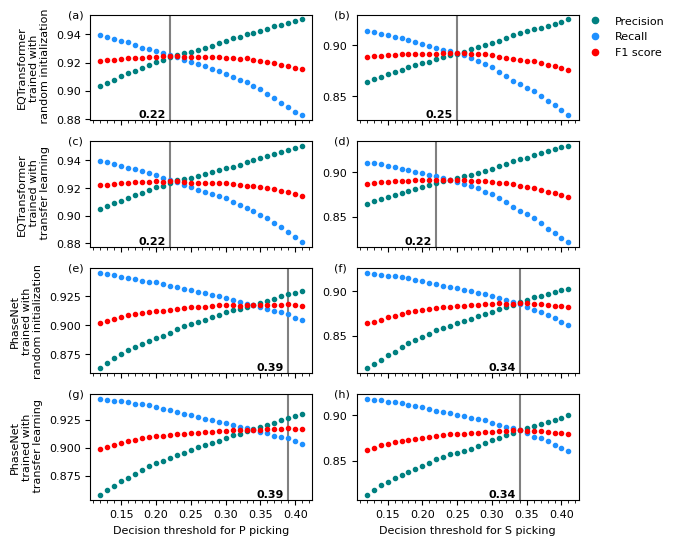

In [6]:
fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(4, 2, figsize=(16 * cm, 16 * cm), sharex="all")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    eqt_exp_name: "EQTransformer\ntrained with\n random initialization",
    eqt_preinst_exp_name: "EQTransformer\n trained with\n transfer learning",
    pn_exp_name: "PhaseNet\ntrained with\nrandom initialization",
    pn_preinst_exp_name: "PhaseNet\ntrained with\n transfer learning",
}
print(ylabels_dict)
for i, exp_name in enumerate(
    [eqt_exp_name, eqt_preinst_exp_name, pn_exp_name, pn_preinst_exp_name]
):
    print(exp_name)
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        f1score = dev_result[f"{phase}_F1score"]
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")

        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            ax.plot(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre - 0.045,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1,
            f"{opt_thre:.2f}",
            verticalalignment="top",
            horizontalalignment="left",
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        ax.xaxis.set_major_locator(MultipleLocator(0.05))
        ax.xaxis.set_minor_locator(MultipleLocator(0.01))
        # print(opt_thre)

    axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
axs[0][1].legend(
    loc="lower left",
    bbox_to_anchor=(0.98, 0.5, 0.3, 0.5),
    frameon=False,
    markerscale=1.5,
    fontsize=fts,
    ncols=1,
)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.1,
        1.05,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
plt.savefig(
    "threshold_tuning_preferred_models.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

{'e_1024_1e-03_ga20_400_s': 'Retrained EQTransformer', 'e_1024_1e-03_ga20_400_s_preinstance': 'Retrained EQTransformer', 'p_512_5e-04_ga20_400_s': 'Retrained PhaseNet', 'p_512_5e-04_ga20_400_s_preinstance': 'Retrained PhaseNet'}
e_1024_1e-03_ga20_400_s_preinstance
p_512_5e-04_ga20_400_s


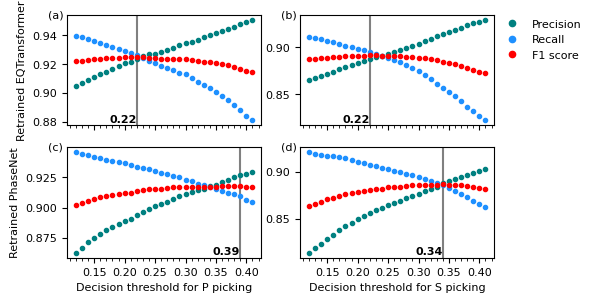

In [15]:
fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(2, 2, figsize=(14 * cm, 8 * cm), sharex="all")
plt.subplots_adjust(wspace=0.2, hspace=0.2)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    eqt_exp_name: "EQTransformer\ntrained with\n random initialization",
    eqt_preinst_exp_name: "EQTransformer\n trained with\n transfer learning",
    pn_exp_name: "PhaseNet\ntrained with\nrandom initialization",
    pn_preinst_exp_name: "PhaseNet\ntrained with\n transfer learning",
}

ylabels_dict = {
    eqt_exp_name: "Retrained EQTransformer",
    eqt_preinst_exp_name: "Retrained EQTransformer",
    pn_exp_name: "Retrained PhaseNet",
    pn_preinst_exp_name: "Retrained PhaseNet",
}

print(ylabels_dict)
for i, exp_name in enumerate([eqt_preinst_exp_name, pn_exp_name]):
    print(exp_name)
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Eval_tune/all_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        f1score = dev_result[f"{phase}_F1score"]
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")

        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            ax.plot(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre - 0.045,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.1,
            f"{opt_thre:.2f}",
            verticalalignment="top",
            horizontalalignment="left",
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        ax.xaxis.set_major_locator(MultipleLocator(0.05))
        ax.xaxis.set_minor_locator(MultipleLocator(0.01))
        # print(opt_thre)

    axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
axs[0][1].legend(
    loc="lower left",
    bbox_to_anchor=(0.98, 0.5, 0.3, 0.5),
    frameon=False,
    markerscale=1.5,
    fontsize=fts,
    ncols=1,
)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.1,
        1.05,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
plt.savefig(
    "threshold_tuning_preferred_models_presentation.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

Original model

In [19]:
org_model_pred_save_path = Path(
    "/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0"
)

In [20]:
df_org_models = pd.read_csv(org_model_pred_save_path / "optimal_threshold.csv")
df_org_models_expnames = df_org_models["exp_name"].values

In [21]:
df_org_models

,exp_name,model,tp_thre,p_opt_prob_thre,s_opt_prob_thre,dev_p_TP,dev_p_FP,dev_p_FN,dev_p_precision,dev_p_recall,...,dev_s_modified_std,dev_s_modified_RMSE,dev_s_modified_MAE,dev_s_modified_MAD,dev_s_modified_mean2,dev_s_modified_median2,dev_s_modified_std2,dev_s_modified_RMSE2,dev_s_modified_MAE2,dev_s_modified_MAD2
0,PhaseNet_org_instance,PhaseNet,0.5,0.13,0.050,11860.0,2307.0,3330.0,0.837157,0.780777,...,0.434569,0.438392,0.273991,0.10,-0.046065,-0.04,0.240054,0.244422,0.154958,0.08
1,PhaseNet_org_incorrect_component_order,PhaseNet,0.5,0.28,0.170,10021.0,3364.0,5169.0,0.748674,0.659710,...,0.496716,0.498607,0.325817,0.10,0.071647,0.06,0.239444,0.249922,0.158796,0.07
2,EQTransformer_org,EQTransformer,0.5,0.01,0.001,8544.0,1979.0,6646.0,0.811936,0.562475,...,0.478093,0.496906,0.322626,0.12,0.024431,0.01,0.241473,0.242695,0.153513,0.08
3,EQTransformer_org_instance,EQTransformer,0.5,0.04,0.040,12209.0,2404.0,2981.0,0.835489,0.803752,...,0.462165,0.462832,0.302713,0.13,-0.047682,-0.03,0.253253,0.257691,0.171552,0.10
4,PhaseNet_org,PhaseNet,0.5,0.25,0.190,11508.0,2628.0,3682.0,0.814092,0.757604,...,0.434307,0.443275,0.273623,0.08,0.080838,0.06,0.206279,0.221545,0.140363,0.06
5,EQTransformer_org_nonconservative,EQTransformer,0.5,0.26,0.150,9973.0,4558.0,5217.0,0.686326,0.656550,...,0.407419,0.407911,0.245305,0.09,0.014730,0.01,0.229642,0.230104,0.142601,0.07
6,PhaseNet_org_stead,PhaseNet,0.5,0.01,0.040,8848.0,3510.0,6342.0,0.715973,0.582488,...,0.476376,0.476707,0.300941,0.11,0.010177,0.01,0.238255,0.238461,0.146804,0.08
7,EQTransformer_org_stead,EQTransformer,0.5,0.02,0.010,9847.0,2217.0,5343.0,0.816230,0.648255,...,0.479051,0.479531,0.307105,0.12,0.006562,0.01,0.237699,0.237778,0.151068,0.08


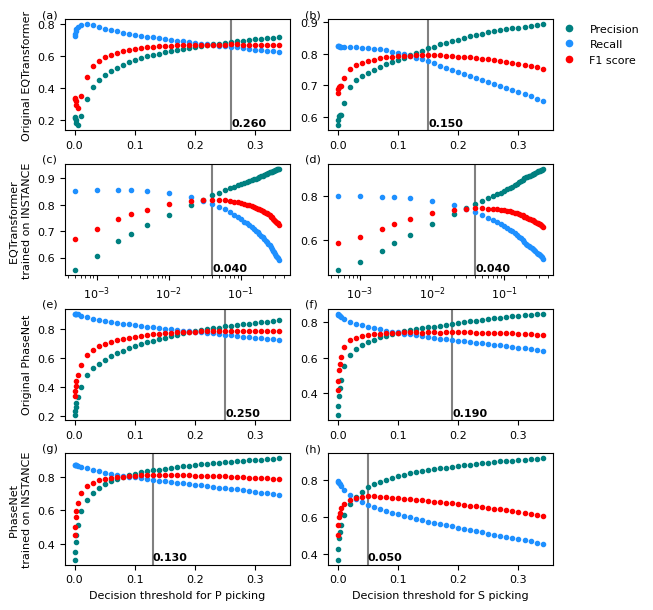

In [12]:
df_org_models_expnames = [
    # "EQTransformer_org",
    "EQTransformer_org_nonconservative",
    "EQTransformer_org_instance",
    "PhaseNet_org",
    "PhaseNet_org_instance",
]
fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(4, 2, figsize=(16 * cm, 18 * cm))
plt.subplots_adjust(wspace=0.17, hspace=0.30)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    # "EQTransformer_org": "Original EQTransformer",
    "EQTransformer_org_nonconservative": "Original EQTransformer",
    "EQTransformer_org_instance": "EQTransformer \ntrained on INSTANCE",
    "PhaseNet_org_instance": "PhaseNet \ntrained on INSTANCE",
    "PhaseNet_org": "Original PhaseNet",
}

for i, exp_name in enumerate(df_org_models_expnames):
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        # f1score = dev_result[f"{phase}_F1score"]
        f1score = 1 / (
            1 / dev_result[f"{phase}_recall"] + 1 / dev_result[f"{phase}_precision"]
        )
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")

        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            if opt_thre < 0.05:
                plot_func = ax.semilogx
            else:
                plot_func = ax.plot
            plot_func(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02,
            f"{opt_thre:.3f}",
            verticalalignment="bottom",
            horizontalalignment="left",
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        # print(opt_thre)
    axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[0][1].legend(
    loc="lower left",
    bbox_to_anchor=(0.98, 0.5, 0.3, 0.5),
    frameon=False,
    markerscale=1.5,
    fontsize=fts,
    ncols=1,
)
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.1,
        1.09,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
plt.savefig(
    "threshold_tuning_original_models.pdf", dpi=600, bbox_inches="tight", pad_inches=0
)

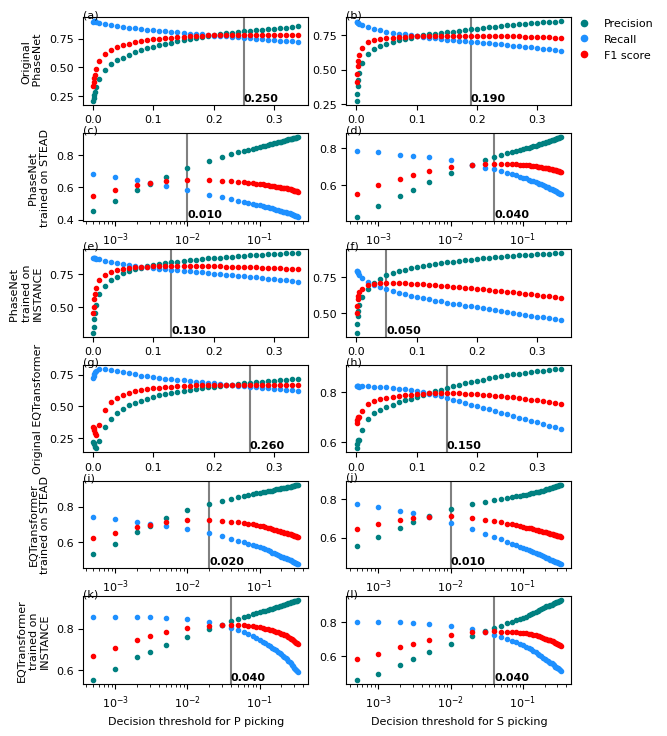

In [32]:
df_org_models_expnames = [
    "PhaseNet_org",
    "PhaseNet_org_stead",
    "PhaseNet_org_instance",
    # "EQTransformer_org",
    "EQTransformer_org_nonconservative",
    "EQTransformer_org_stead",
    "EQTransformer_org_instance",
]
fts = 8
cm = 1 / 2.54
fig, axs = plt.subplots(6, 2, figsize=(16 * cm, 22 * cm))
plt.subplots_adjust(wspace=0.17, hspace=0.32)
colors = ["teal", "dodgerblue", "red"]
metrics_labels = {"precision": "Precision", "recall": "Recall", "F1score": "F1 score"}
ylabels_dict = {
    "EQTransformer_org_nonconservative": "Original EQTransformer",
    "EQTransformer_org": "Original\n EQTransformer",
    "EQTransformer_org_instance": "EQTransformer\ntrained on\nINSTANCE",
    "EQTransformer_org_stead": "EQTransformer\ntrained on STEAD",
    "PhaseNet_org_stead": "PhaseNet \ntrained on STEAD",
    "PhaseNet_org_instance": "PhaseNet \ntrained on\nINSTANCE",
    "PhaseNet_org": "Original\n PhaseNet",
}

for i, exp_name in enumerate(df_org_models_expnames):
    dev_result = pd.read_csv(
        f"/home/zhongyiyuan/volpick/model_training/Original_model_opt_thresholds/all_pred/task0/{exp_name}/dev_metrics.csv"
    )
    prob_thre = dev_result["prob_thre"]
    for j, phase in enumerate(["p", "s"]):
        ax = axs[i][j]
        # precision = pn_dev_result[f"{phase}_precision"]
        # recall = pn_dev_result[f"{phase}_recall"]
        # F1score = pn_dev_result[f"{phase}_F1score"]
        # f1score = dev_result[f"{phase}_F1score"]
        f1score = 1 / (
            1 / dev_result[f"{phase}_recall"] + 1 / dev_result[f"{phase}_precision"]
        )
        opt_thre = prob_thre[np.argmax(f1score)]
        ax.axvline(opt_thre, color="grey")

        for k, metric_name in enumerate(["precision", "recall", "F1score"]):
            metric_value = dev_result[f"{phase}_{metric_name}"]
            if opt_thre < 0.05:
                plot_func = ax.semilogx
            else:
                plot_func = ax.plot
            plot_func(
                prob_thre,
                metric_value,
                color=colors[k],
                label=metrics_labels[metric_name],
                marker=".",
                linestyle="",
            )
            ax.tick_params(labelsize=fts)
        ax.text(
            opt_thre,
            # 0.88,
            ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02,
            f"{opt_thre:.3f}",
            verticalalignment="bottom",
            horizontalalignment="left",
            # transform=ax.transAxes,
            fontsize=fts,
            weight="bold",
            color="black",
        )
        # print(opt_thre)
    axs[i][0].set_ylabel(ylabels_dict[exp_name], fontsize=fts)
axs[0][1].legend(
    loc="lower left",
    bbox_to_anchor=(0.96, 0.4, 0.3, 0.5),
    frameon=False,
    markerscale=1.5,
    fontsize=fts,
    ncols=1,
)
axs[-1][0].set_xlabel("Decision threshold for P picking", fontsize=fts)
axs[-1][1].set_xlabel("Decision threshold for S picking", fontsize=fts)
for i, ax in enumerate(axs.flat):
    ax.text(
        -0.0,
        1.09,
        "(" + chr(97 + i) + ")",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        fontsize=fts,
        # weight="bold",
        color="black",
    )
# plt.savefig(
#     "threshold_tuning_original_models.eps", dpi=600, bbox_inches="tight", pad_inches=0
# )